In [37]:
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
from scipy import interpolate
import skimage.color
import skimage.transform
import itertools

import urllib.request as request

def plot_neigborhood(x, y, P, R):
    plt.scatter(x, y)
    plt.axis('square')
    plt.grid(True)
    plt.title('Cicle with P={p} and R={r}'.format(p=P, r=R))
    plt.xticks(np.arange(-2, 3, 1.0))
    plt.yticks(np.arange(-2, 3, 1.0))
    plt.show()
    
def load_image(url, as_gray=False):
    image_stream = request.urlopen(url)
    return skimage.io.imread(image_stream, as_gray=as_gray, plugin='pil')


def create_index(s_T):
    n_ones = np.sum(s_T)
    s_T_size = len(s_T)
    
    if 1 in s_T:
        first_one = list(s_T).index(1)
    else:
        first_one = -1
    
    if 0 in s_T:
        first_zero = list(s_T).index(0)
    else:
        first_zero = -1
    
    if n_ones == 0:
        return 0
    elif n_ones == s_T_size:
        return s_T_size * (s_T_size - 1) + 1
    else:
        if first_one == 0:
            rot_index = n_ones - first_zero
        else:
            rot_index = s_T_size - first_one
        return 1 + (n_ones - 1) * s_T_size + rot_index    

In [38]:
url = 'https://cdn.pixabay.com/photo/2015/12/26/08/20/red-1108405_1280.jpg'
img = load_image(url, False)
img = skimage.transform.rescale(img, scale=(1/2, 1/2), anti_aliasing=True, mode='reflect', multichannel=True)
img_gray = skimage.color.rgb2gray(img)

# Image Feature Extraction: Local Binary Patterns in Cython

# Introduction

The common goal of feature extraction is to represent the raw data as a reduced set of features that better describe their main features and attributes [1]. This way, we can reduce the dimentionality of the original input and use the new features as an input to train pattern recognition and classification techniques.

Although there are several features that we can extract from a picture, Local Binary Patterns (LBP) is a theoretically simple, yet efficient approach to gray scale and rotation invariant textur classification. They work because the most frequent patterns correspond to primitive microfeatures such as edges, corners, spots, flat regions [2].

In [2], Ojala et al. shown that the discrete occurence histogram of the uniform patterns are a very powerful texture feature. Image texture is defined as a two dimentional phenomenon characterized by two properties: (1) spatial structure (pattern) and (2) contrast.

The image that we are going to use to test each step of the methodology is the following:

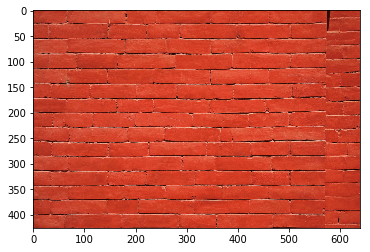

In [10]:
_ = plt.imshow(img)

# Methodology

## Circularly Symmetric Neighbor Set

A circularly symmetric neighbor set for a given pixel $g_c$ is defined by the points with coordinates (i, j) that surround the central point on a circle of radius R, and number of elements P.

$$i = -R\sin\big(\frac{2\pi p}{ P}\big);\hspace{1em}j = R\cos\big(\frac{2\pi p}{P}\big)\hspace{1em}\forall\hspace{0.5em}p \in \{0, 1, ..., P\}$$

In [11]:
def neighborhood(P, R):
    x = np.arange(0, P)
    x = R * np.cos(2 * np.pi * x / P)
    
    y = np.arange(0, P)
    y = - R * np.sin(2 * np.pi * y / P)
    
    return x, y

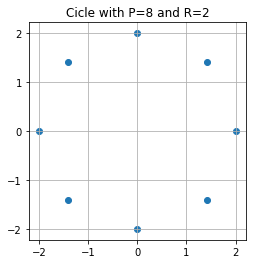

In [12]:
R = 2
P = 8

x, y = neighborhood(P, R)

plot_neigborhood(x, y, P, R)

## Texture
We define a texture *T* as the collection of pixels in a gray scale image

$$T \approx t(g_c, g_0, g_1, ..., g_{P-1})$$

where $g_p$ corresponds to the gray value of the *p* local neighboor.

## Interpolation

When a neighbor is not located in the center of a pixel, that neighbor gray value should be calculated by interpolation. Thus, we need to define a function that given a coordinate, returns the interpolated gray value.

In [13]:
def interpolate2d(gray_img, kind='cubic'):
    """
    Returns a function f(x,y) that returns the interpolated value
    of gray_img where (x,y) is the coordinate.
    """
    assert gray_img.ndim == 2, 'It should be a two dimentional image (gray)'
    h, w = gray_img.shape

    x = np.arange(0, w)
    y = np.arange(0, h)

    return interpolate.interp2d(x, y, gray_img, kind=kind)

def calculate_neiborhood_values(x, y, interpolation_function):
    gray_values = map(lambda pt: interpolation_function(*pt), zip(x, y))
    return np.fromiter(gray_values, float)

In [14]:
x0 = 400
y0 = 400

xp = x + x0
yp = y + y0

f = interpolate2d(img_gray, kind='cubic')

print('Neigborhood gray values:\n', img_gray[y0 - R: y0 + R + 1, x0 - R: x0 + R + 1])
print('\nNeighborhood interpolations:', calculate_neiborhood_values(xp, yp, f))

Neigborhood gray values:
 [[0.28469957 0.22251419 0.1416961  0.11137357 0.10808686]
 [0.6750711  0.68231269 0.64075085 0.61409498 0.7055542 ]
 [0.45878441 0.45841089 0.40969545 0.40214504 0.40703542]
 [0.40217126 0.41505837 0.40242607 0.41808553 0.38051779]
 [0.42724818 0.40458319 0.39175411 0.37149769 0.36736198]]

Neighborhood interpolations: [0.40703542 0.46860115 0.1416961  0.55025901 0.45878441 0.41959682
 0.39175411 0.40042768]


## Achieving Gray-Scale Invariance

Considering a possible loss of information, it is possible to turn the texture into the joint difference. To calculate it, we substract the gray value of the central pixel to all of the neighbor set. The joint difference distribution is a highly discriminative texture operator. It records the ocurrences of various patterns in the neighborhood of each pixel in a P-dimentional histogram.

$$T \approx t(g_0 - g_c, g_1 - g_c, ... g_{P-1} - g_c)$$

where $g_0$ is the gray value of the center pixel and $g_p$ is the gray value of the $p$ neighbor. This distribution is invariant against gray-scale shifts.

In [15]:
def joint_difference_distribution(gray_img, gc, x, y, interpolation_f):
    xc, yc = gc
    
    xp = xc + x
    yp = yc + y
    
    g_p = calculate_neiborhood_values(xp, yp, interpolation_f)
    g_c = interpolation_f(xc, yc)
    
    return np.round(g_p - g_c, 15)

In [16]:
print('The joint difference distribution is:\n', joint_difference_distribution(img_gray, (x0, y0), x, y, f))

The joint difference distribution is:
 [-0.00266002  0.05890571 -0.26799935  0.14056356  0.04908897  0.00990137
 -0.01794134 -0.00926777]


## Local Binary Pattern

$LBP_{P,R}$ operater is by definition invariant against any monotonic transformation of the gray scale. As long as the order of the gray values stays the same, the output of the $LBP_{P,R}$ operator remains constant.

$$LBP_{P,R} = \sum_{p=0}^{P-1} s(g_p - g_c) 2^p$$

where 

$$s(x) = 
\begin{cases} 
    1 & x\geq0 \\
    0 & x<0
\end{cases}
$$

In [17]:
def binary_joint_distribution(gray_img, gc, x, y, interpolation_f):
    T = joint_difference_distribution(gray_img, gc, x, y, interpolation_f)
    return np.where(T >= 0, 1, 0)

def LBP(gray_img, gc, x, y, interpolation_f):
    s = binary_joint_distribution(gray_img, gc, x, y, interpolation_f)
    p = np.arange(0, P)
    binomial_factor = 2 ** p
    return np.sum(binomial_factor * s)

In [18]:
print('The joint difference distribution is:\n', joint_difference_distribution(img_gray, (x0, y0), x, y, f))
print('The binary joint distribution is:\n', binary_joint_distribution(img_gray, (x0, y0), x, y, f))
print('LBP:\n', LBP(img_gray, (x0, y0), x, y, f))

The joint difference distribution is:
 [-0.00266002  0.05890571 -0.26799935  0.14056356  0.04908897  0.00990137
 -0.01794134 -0.00926777]
The binary joint distribution is:
 [0 1 0 1 1 1 0 0]
LBP:
 58


### Uniform Local Binary Patterns

In [2], Ojala mentions that in their practical experience LBP is not a good discriminator. They propose just to select the set of local binary patterns such that the number of spatial transitions (bitwise 0/1 changes) does not exeed 2. For example, the pattern '1111' has 0 spatial transitions, the pattern '1100' has 1 spatial transitions and the pattern '1101' has 2 spatial transitions. To each uniform pattern, a unique index is associated. 

The formula to create the index was borrowed from https://github.com/scikit-image/scikit-image/blob/master/skimage/feature/_texture.pyx

In [19]:
def is_uniform(pattern):
    count = 0
    for idx in range(len(pattern) - 1):
        count += pattern[idx] ^ pattern[idx + 1]
        if count > 2:
            return False
    return True

def uniform_patterns(P):
    patterns = itertools.product([0, 1], repeat=P)
    u_patterns = [pattern for pattern in patterns if is_uniform(pattern)]
    
    return [''.join(str(elem) for elem in elems) for elems in u_patterns]

def LBP_uniform(gray_img, gc, x, y, interpolation_f, uniform_patterns):
    s = binary_joint_distribution(gray_img, gc, x, y, f)
    pattern = ''.join([str(elem) for elem in s])
    
    return create_index(s) if pattern in uniform_patterns else 2 + P * (P - 1)

In [20]:
u_patterns = uniform_patterns(P)

print('The joint difference distribution is:\n', joint_difference_distribution(img_gray, (x0, y0), x, y, f))
s_T = binary_joint_distribution(img_gray, (x0, y0), x, y, f)
print('The binary joint distribution is:\n', s_T)
print('LBP:\n', LBP(img_gray, (x0, y0), x, y, f))
print('Is {} a uniform pattern: {}\n'.format(s_T, is_uniform(s_T)))
print('LBP_uniform:', LBP_uniform(img_gray, (x0, y0), x, y, f, u_patterns))

The joint difference distribution is:
 [-0.00266002  0.05890571 -0.26799935  0.14056356  0.04908897  0.00990137
 -0.01794134 -0.00926777]
The binary joint distribution is:
 [0 1 0 1 1 1 0 0]
LBP:
 58
Is [0 1 0 1 1 1 0 0] a uniform pattern: False

LBP_uniform: 58


Now, we can calculate the local binary patterns for a central pixel. The next step is to calculate the local binary patterns for all the fixels.

*Hint: For siplicity sake, I am not considering the case where a selected index is negative (i.e. img_gray[-1][0] returns the last pixel of the first column). If we would want to have the most accurate calculation, we should consider this case and treat it. 

In [21]:
%%time

R = 2
P = 8

x, y = neighborhood(P, R)
h, w = img_gray.shape
f = interpolate2d(img_gray, kind='cubic')

LBP_image = np.zeros((h, w))

for j in range(h):
    for i in range(w):
        LBP_image[j, i] = LBP_uniform(img_gray, (i, j), x, y, f, u_patterns)

CPU times: user 1min 10s, sys: 50 ms, total: 1min 10s
Wall time: 1min 10s


In [22]:
print('The LBP image is:', LBP_image)

The LBP image is: [[55. 57. 58. ... 48. 31. 58.]
 [37. 54. 36. ... 58. 47. 53.]
 [ 5.  0. 58. ... 58. 56. 57.]
 ...
 [50.  0.  0. ... 53. 58. 58.]
 [58. 16.  6. ... 58.  3. 57.]
 [48. 48. 57. ... 58.  3. 46.]]


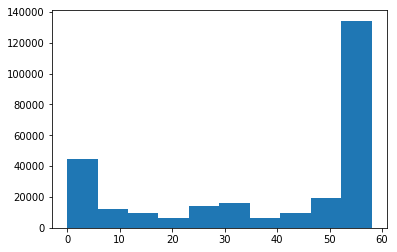

In [23]:
_ = plt.hist(LBP_image.ravel())

# Cython Code

The previous code is not perfect; however, what makes it really slow is that we iterate through all the image pixels. Waiting 1 minute and 10 seconds to calculate our features is a lot, if we take into account that we have also to traini a pattern recognition technique. Thus, we need an alternative implementation that must be much faster for loops. In this case, we will use Cython. The code is presented in the next image, it is a big chunk of code. Some parts of if could be improved, but it is already much faster. Please feel free to leave comments if you don't understand something from the code.

The code is written in such a way that most of it runs entirely in the C API. This strategy speeds up the execution considerably, but also allow us to take advantage of cython's parallel module. We will split the job across multiple
cores in the CPU.

In [33]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [34]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp

from libc.math cimport sin, cos, pi, ceil, floor, pow
from libc.stdlib cimport abort, malloc, free
import numpy as np
cimport numpy as np
cimport cython
from cython.parallel import prange, parallel
cimport openmp


cdef double get_pixel2d(
    double *image,
    Py_ssize_t n_rows, 
    Py_ssize_t n_cols,
    long x,
    long y) nogil:
    
    if (y < 0) or (y >= n_rows) or (x < 0) or (x >= n_cols):
        return 0
    else:
        return image[y * n_cols + x]

    
cdef double bilinear_interpolation(
    double *image,
    Py_ssize_t n_rows,
    Py_ssize_t n_cols,
    double x,
    double y) nogil:
    
    cdef double d_y, d_x, top_left, top_right, bottom_left, bottom_right
    cdef long min_y, min_x, max_y, max_x

    min_y = <long>floor(y)
    min_x = <long>floor(x)
    max_y = <long>ceil(y)
    max_x = <long>ceil(x)
    
    d_y = y - min_y
    d_x = x - min_x
    
    top_left = get_pixel2d(image, n_rows, n_cols, min_x, min_y)
    top_right = get_pixel2d(image, n_rows, n_cols, max_x, min_y)
    bottom_left = get_pixel2d(image, n_rows, n_cols, min_x, max_y)
    bottom_right = get_pixel2d(image, n_rows, n_cols, max_x, max_y)
    
    top = (1 - d_x) * top_left + d_x * top_right
    bottom = (1 - d_x) * bottom_left + d_x * bottom_right

    return (1 - d_y) * top + d_y * bottom


cdef double *joint_difference_distribution(
    double *image,
    Py_ssize_t n_rows,
    Py_ssize_t n_cols,
    int x0,
    int y0,
    int P,
    int R
) nogil:
    cdef Py_ssize_t p
    cdef double *T = <double *> malloc(sizeof(double) * P)
    cdef double x, y, gp, gc
    
    if T is NULL:
        abort()
        
    gc = get_pixel2d(image, n_rows, n_cols, x0, y0)
    
    for p in range(P):
        x = x0 + R * cos(2 * pi * p / P)
        y = y0 - R * sin(2 * pi * p / P)
        gp = bilinear_interpolation(image, n_rows, n_cols, x, y)
        T[p] = gp - gc
    
    return T


cdef int *binary_joint_distribution(double *T, Py_ssize_t T_size) nogil:
    cdef int *s_T = <int *> malloc(sizeof(int) * T_size)
    cdef Py_ssize_t i = 0
    
    for t in range(T_size):
        if T[t] >= 0.0:
            s_T[t] = 1
        else:
            s_T[t] = 0
    
    return s_T


cdef long LBP(double *T, int *s_T, Py_ssize_t T_size) nogil:
    cdef long LBP_pr = 0
    cdef Py_ssize_t i = 0
    
    for i in range(0, T_size):
        LBP_pr = LBP_pr + 2 ** i * s_T[i]
        
    return LBP_pr


cdef int is_uniform_pattern(int *s_T, Py_ssize_t s_T_size) nogil:
    cdef Py_ssize_t i = 0
    cdef int counter = 0
    
    for i in range(s_T_size - 1):
        if s_T[i] != s_T[i + 1]:
            counter += 1
        
        if counter > 2:
            return 0
    return 1


cdef int create_index(int *s_T, Py_ssize_t s_T_size) nogil:
    cdef int n_ones = 0
    cdef int rot_index = -1
    cdef int first_one = -1
    cdef int first_zero = -1
    cdef int lbp = -1

    cdef Py_ssize_t i
    for i in range(s_T_size):
        if s_T[i]:
            n_ones += 1
            if first_one == -1:
                first_one = i
        else:
            if first_zero == -1:
                first_zero = i
    
    if n_ones == 0:
        lbp = 0
    elif n_ones == s_T_size:
        lbp = s_T_size * (s_T_size - 1) + 1
    else:
        if first_one == 0:
            rot_index = n_ones - first_zero
        else:
            rot_index = s_T_size - first_one
        lbp = 1 + (n_ones - 1) * s_T_size + rot_index
    return lbp


cdef int LBP_uniform(int *s_T, Py_ssize_t s_T_size) nogil:
    cdef int LBP_pru = 0
    cdef Py_ssize_t i = 0
    
    if is_uniform_pattern(s_T, s_T_size):
        LBP_pru = create_index(s_T, s_T_size)
    else:
        LBP_pru = 2 + s_T_size * (s_T_size - 1)
        
    return LBP_pru


@cython.boundscheck(False)
@cython.wraparound(False)
def local_binary_patterns(
    double[:, ::1] image,
    int P,
    int R,
    int num_threads=1
):
    
    cdef Py_ssize_t x = 0
    cdef Py_ssize_t y = 0
    cdef int n_rows = image.shape[0]
    cdef int n_cols = image.shape[1]
    cdef int[:, ::1] lbp = np.zeros([n_rows, n_cols], dtype=np.int32) 
    
    with nogil, parallel(num_threads=num_threads):
        for y in prange(n_rows, schedule='static'):
            for x in prange(n_cols, schedule='static'):
                T = joint_difference_distribution(&image[0][0], n_rows, n_cols, x, y, P, R)
                s_T = binary_joint_distribution(T, P)
                lbp[y, x] = LBP_uniform(s_T, P)
    
    return np.asarray(lbp)

In [42]:
%%time

lbp = local_binary_patterns(img_gray, P, R, num_threads=4)

CPU times: user 410 ms, sys: 30 ms, total: 440 ms
Wall time: 124 ms


Using 4 threads, I can calculate the local binary patterns for all the pixels in less than 150 ms. This is so much more faster that I won't even bother to calculate by how many times.

# Comparison with a Similar Image

Let's take another image of bricks, but this one will have a different texture.

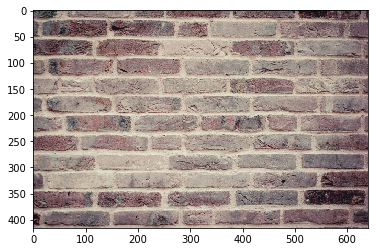

In [56]:
url2 = 'https://cdn.pixabay.com/photo/2014/09/24/16/28/bricks-459299_1280.jpg'

img = load_image(url2, False)
img = skimage.transform.rescale(img, scale=(1/2, 1/2), anti_aliasing=True, mode='reflect', multichannel=True)
img_gray = skimage.color.rgb2gray(img)
_ = plt.imshow(img)

In [57]:
%%time 

lbp2 = local_binary_patterns(img_gray, P, R, num_threads=3)

CPU times: user 360 ms, sys: 10 ms, total: 370 ms
Wall time: 136 ms


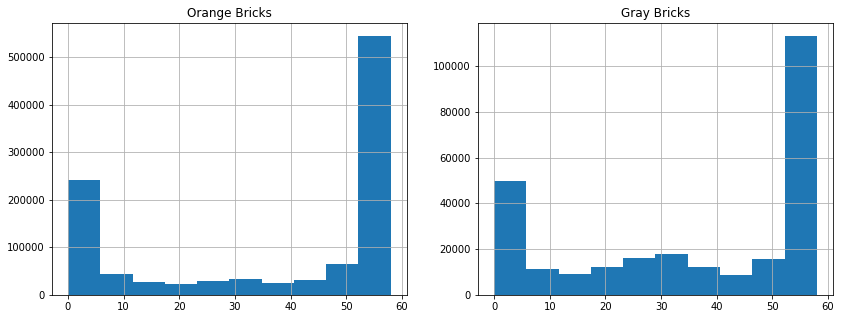

In [66]:
figure = plt.figure(figsize=(14, 5))

plt.subplot(121)
plt.hist(lbp.ravel())
plt.title('Orange Bricks')
plt.grid(True)

plt.subplot(122)
plt.hist(lbp2.ravel())
plt.title('Gray Bricks')
plt.grid(True)

plt.show()

Both histograms are very similar, and they should be, both of them are bricks. Nonetheless, features from 20 to 40 are very disimilar in both images. It means that with a good machine learning algorithm we could correctly classify them.

# Conclusion

Local binary patterns are siple but efficient features. The theory behind is not hard to understand and they are easy to code. Nevertheless, if we code them entirely with Python, we will have some performance issues. We tackled the problem with Cython and we got very impressive results. The next step is to collect different texture images and train your favorite machine learning algorithm to classify them.

# Bibliography

[1] Marques, O. (2011). Practical image and video processing using MATLAB. John Wiley & Sons.

[2] Ojala, T., Pietikäinen, M., & Mäenpää, T. (2002). Multiresolution gray-scale and rotation invariant texture classification with local binary patterns. IEEE Transactions on Pattern Analysis and Machine Intelligence, 24(7), 971–987.